In [7]:
import os
from typing import Dict, List, Tuple, Optional
import calendar
from datetime import datetime, timedelta
from dataclasses import dataclass

import tqdm

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Data analysis

In [45]:
views_df = pd.read_csv('views.csv', sep=';')
views_df

,Unnamed: 0,2021,2022,2023
0,1,"327,9","327,8","319,9"
1,2,"315,6","329,4","310,3"
2,3,"302,2","316,3","298,1"
3,4,"280,8","296,1","276,0"
4,5,"265,5","282,5","263,6"
5,6,"255,6","260,9","257,9"
6,7,"256,8","256,7","252,9"
7,8,"261,0","259,5","253,6"
8,9,"274,2","277,9","262,4"
9,10,"290,6","292,0","281,9"


In [32]:
views_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12 non-null     int64 
 1   2021        12 non-null     object
 2   2022        12 non-null     object
 3   2023        10 non-null     object
dtypes: int64(1), object(3)
memory usage: 512.0+ bytes


In [46]:
#prepare views
views_df.rename(columns={'Unnamed: 0': 'month'}, inplace=True)
views_df['2021'] = views_df['2021'].apply(lambda x: float(x.replace(',', '.')))
views_df['2022'] = views_df['2022'].apply(lambda x: float(x.replace(',', '.')))
views_df['2023'] = views_df['2023'].apply(lambda x: float(x.replace(',', '.')) if x is not np.nan else x)
views_df

,month,2021,2022,2023
0,1,327.9,327.8,319.9
1,2,315.6,329.4,310.3
2,3,302.2,316.3,298.1
3,4,280.8,296.1,276.0
4,5,265.5,282.5,263.6
5,6,255.6,260.9,257.9
6,7,256.8,256.7,252.9
7,8,261.0,259.5,253.6
8,9,274.2,277.9,262.4
9,10,290.6,292.0,281.9


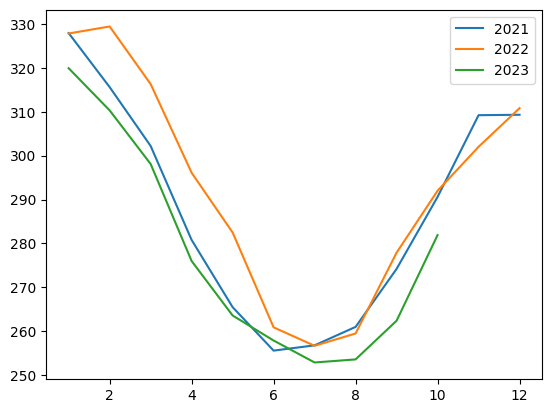

In [52]:
plt.plot(views_df['month'].values, views_df['2021'].values)

plt.plot(views_df['month'].values, views_df['2022'].values)

plt.plot(views_df['month'].values, views_df['2023'].values)
plt.legend(['2021', '2022', '2023'])
plt.show()

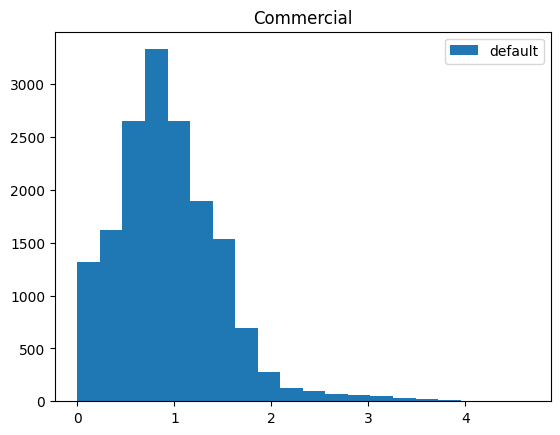

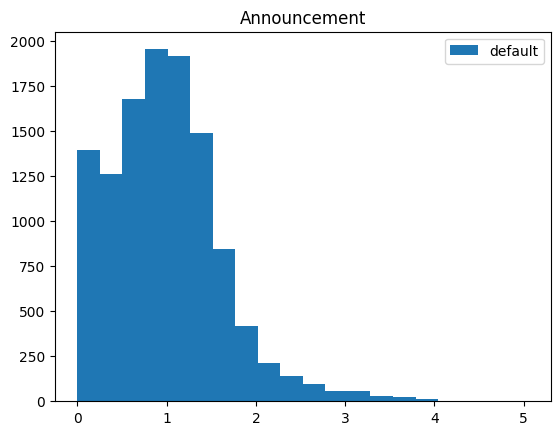

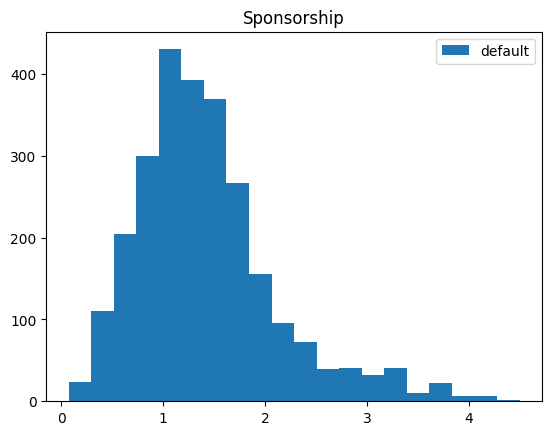

In [95]:
for i in train_df['Break content'].unique():
    plt.hist(train_df.loc[train_df['Break content'] == i, target_column], bins=20)
    plt.legend(['default'])
    plt.title(i)
    plt.show()
    #plt.hist(np.log(train_df.loc[(train_df['Break content'] == i) & (train_df[target_column]>0), target_column].values), bins=20)
    #plt.legend(['log'])
    #plt.title(i)
    #plt.show()

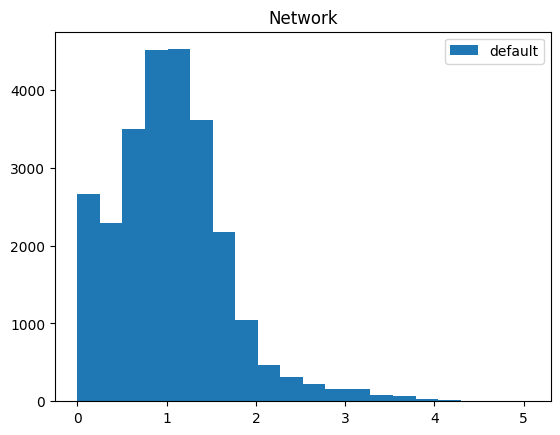

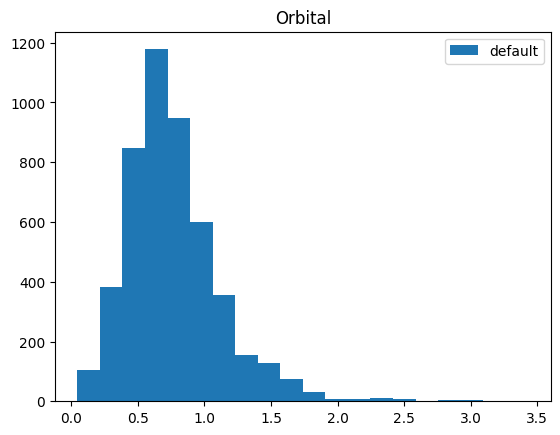

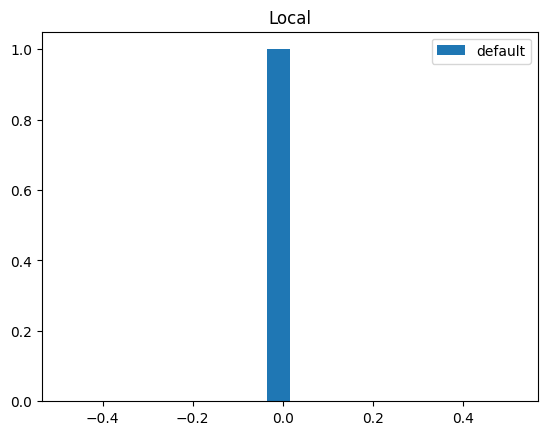

In [96]:
for i in train_df['Break distribution'].unique():
    plt.hist(train_df.loc[train_df['Break distribution'] == i, target_column], bins=20)
    plt.legend(['default'])
    plt.title(i)
    plt.show()
    #plt.hist(np.log(train_df.loc[(train_df['Break content'] == i) & (train_df[target_column]>0), target_column].values), bins=20)
    #plt.legend(['log'])
    #plt.title(i)
    #plt.show()

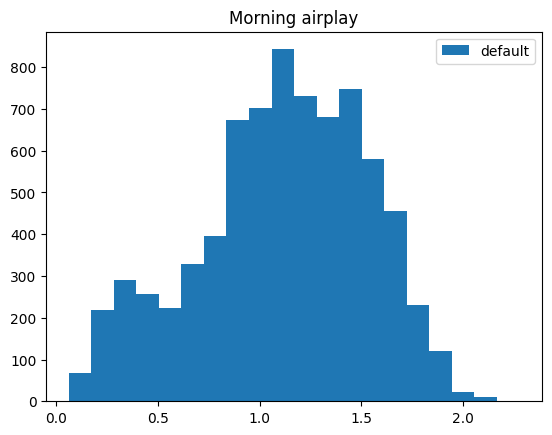

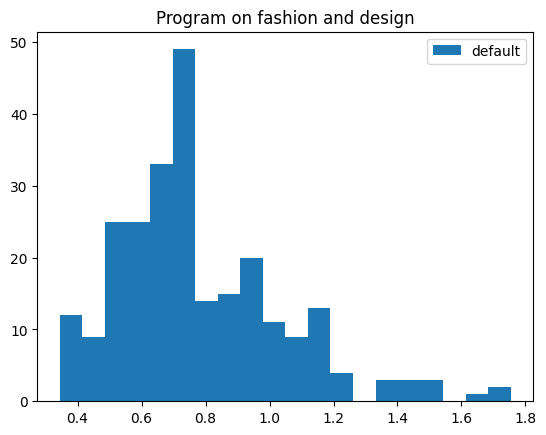

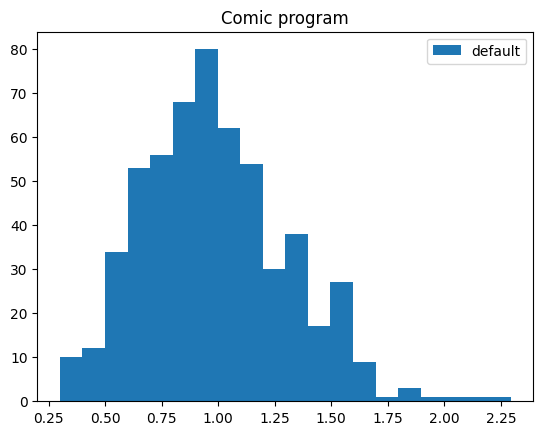

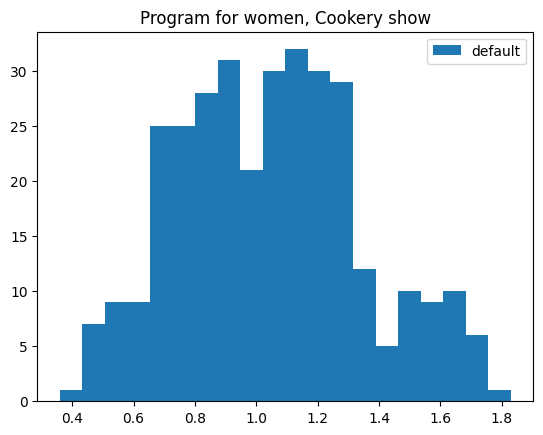

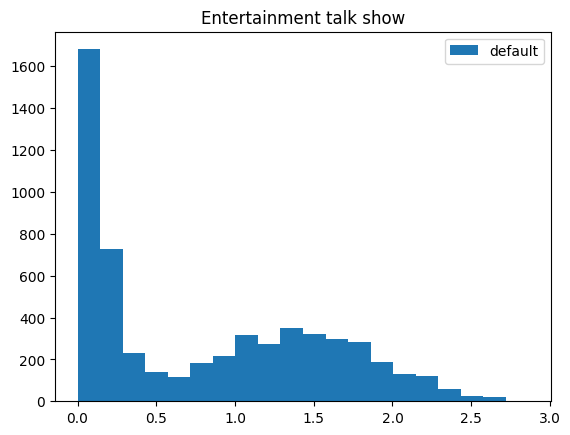

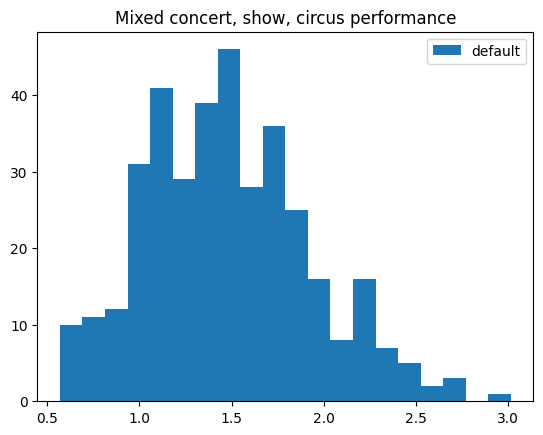

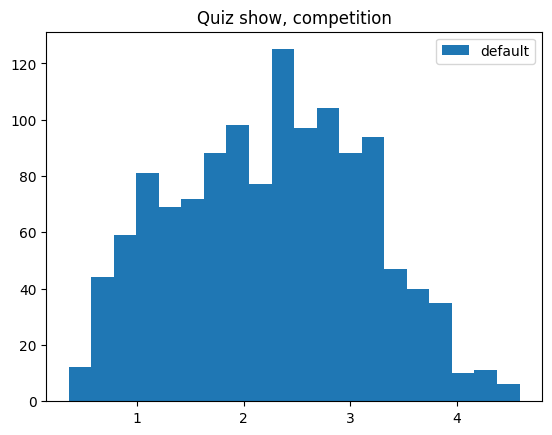

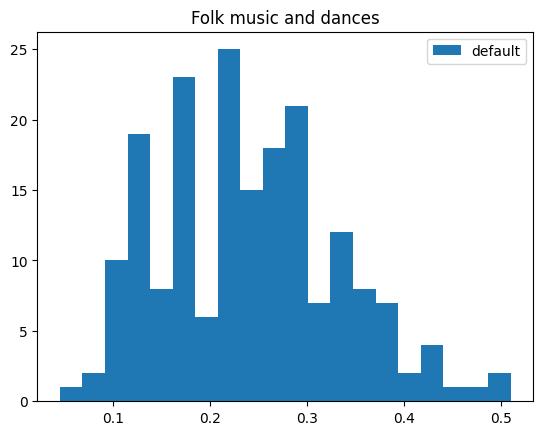

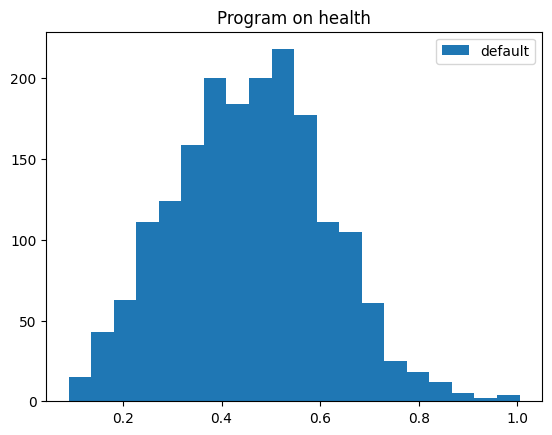

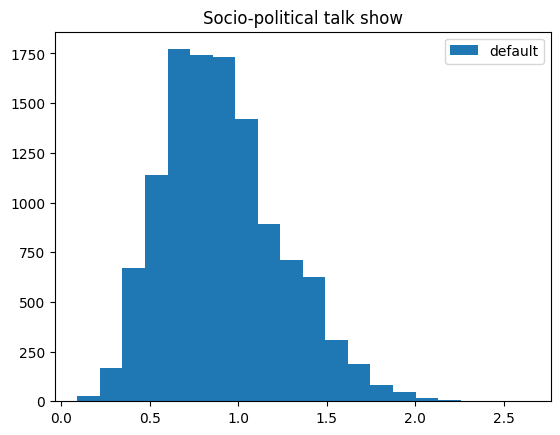

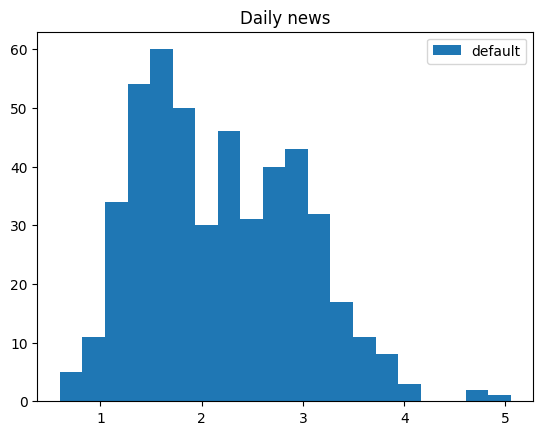

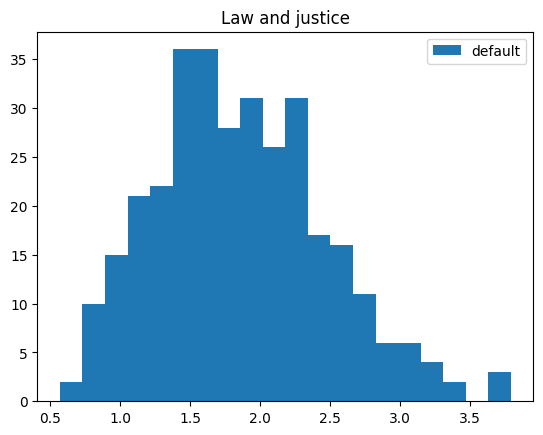

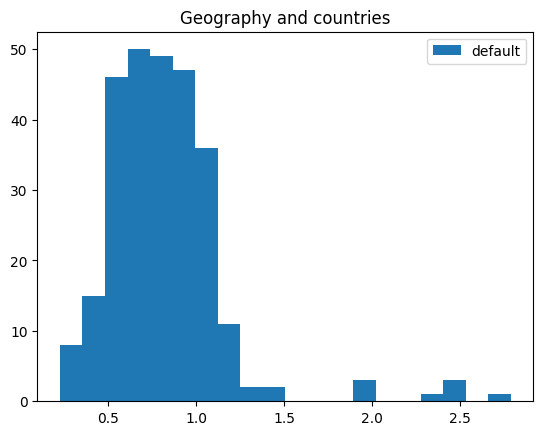

In [99]:
for i in train_df['Programme category'].unique():
    plt.hist(train_df.loc[train_df['Programme category'] == i, target_column], bins=20)
    plt.legend(['default'])
    plt.title(i)
    plt.show()
    #plt.hist(np.log(train_df.loc[(train_df['Break content'] == i) & (train_df[target_column]>0), target_column].values), bins=20)
    #plt.legend(['log'])
    #plt.title(i)
    #plt.show()

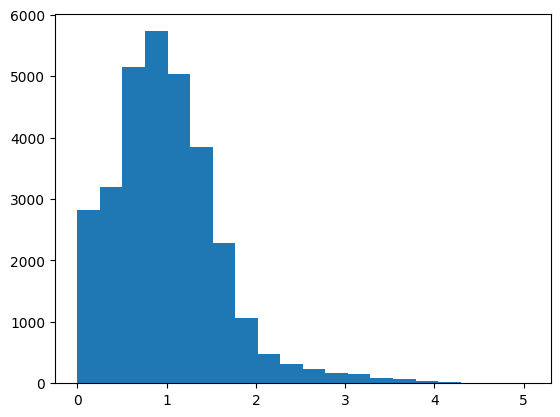

In [86]:
plt.hist(train_df[target_column], bins=20)
plt.show()

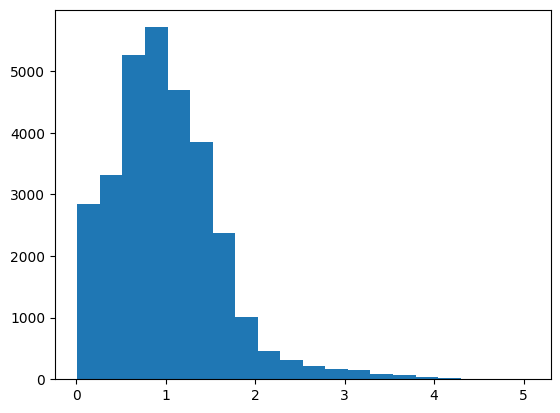

In [90]:
plt.hist((train_df.loc[train_df[target_column]>0, target_column].values), bins=20)
plt.show()

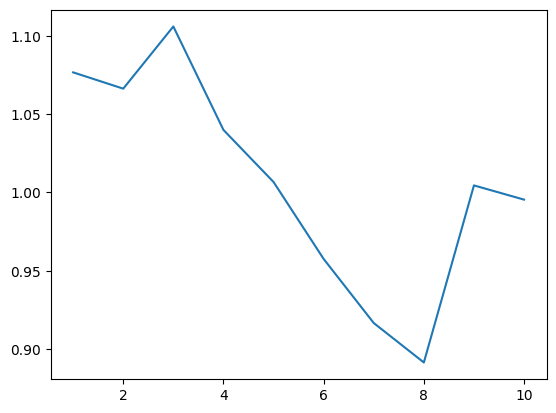

In [109]:
plt.plot(train_df.groupby(by='Date_month')[target_column].mean())

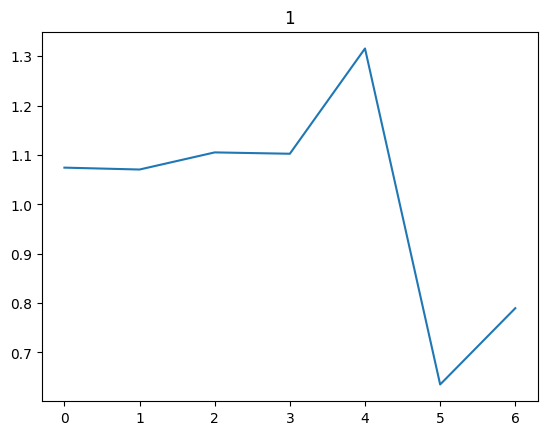

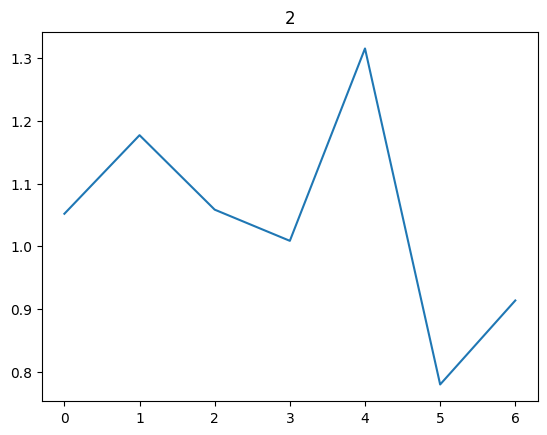

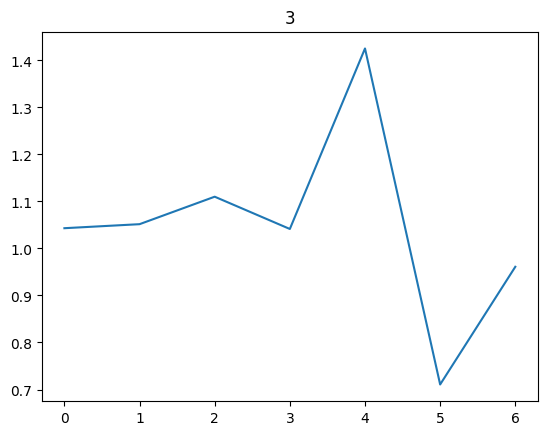

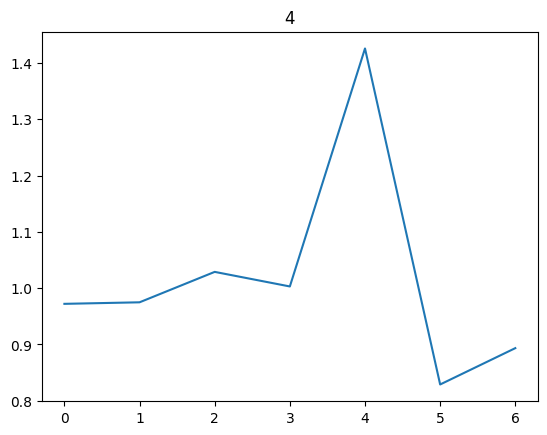

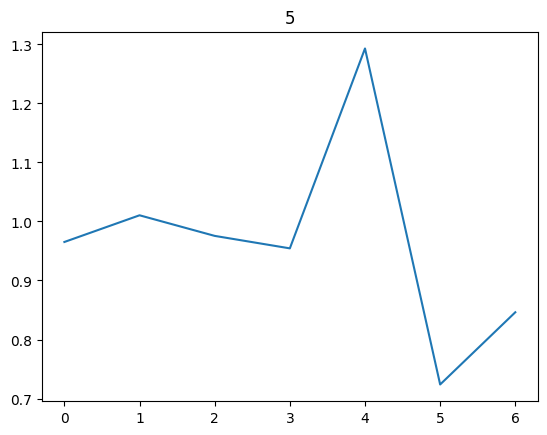

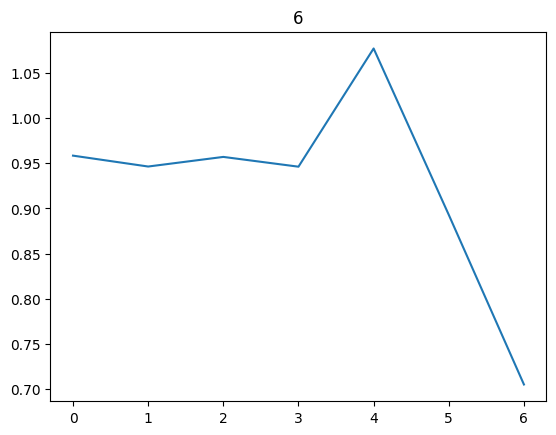

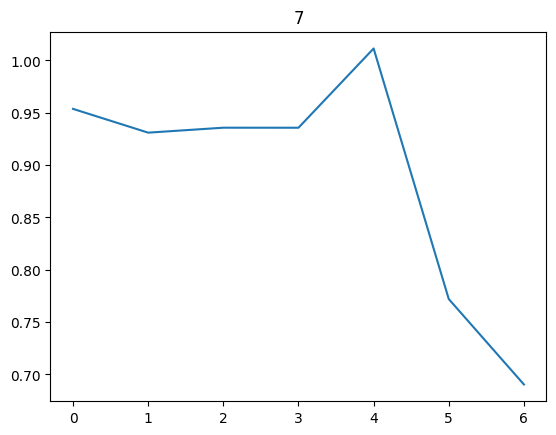

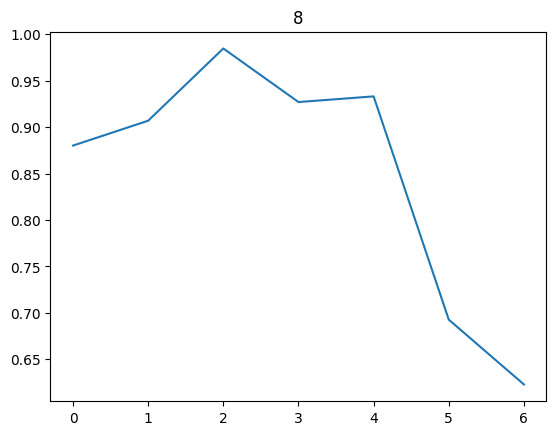

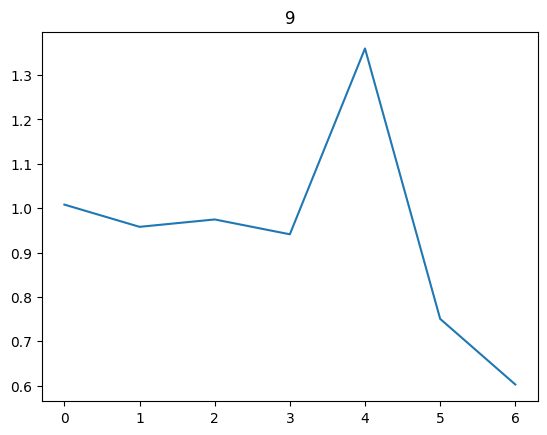

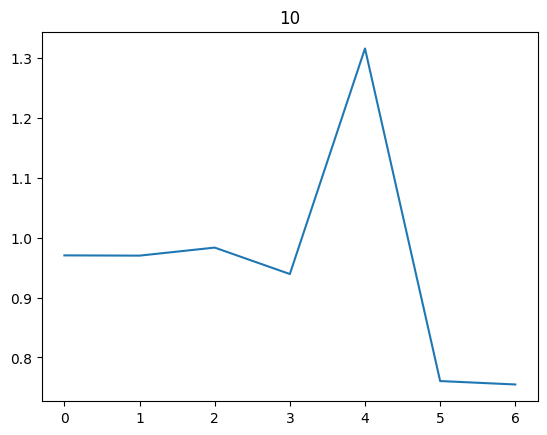

In [242]:
for m in train_df['Date_month'].unique():    
    plt.plot(train_df.loc[train_df['Date_month'] == m].groupby(by='weekday')[target_column].mean())
    plt.title(m)
    plt.show()

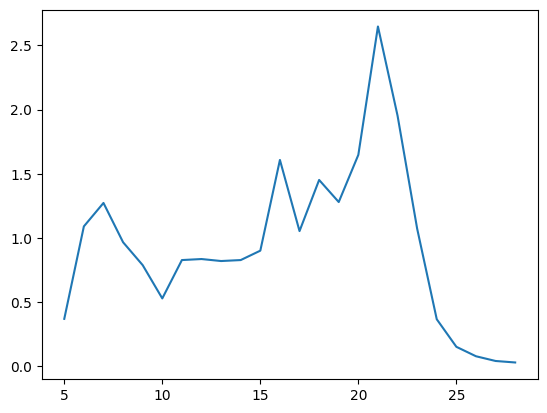

In [247]:
plt.plot(train_df.groupby(by='Break_hour')[target_column].mean())

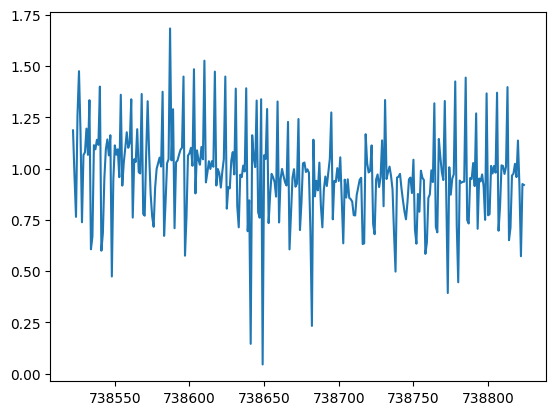

In [249]:
plt.plot(train_df.groupby(by='new_date')[target_column].mean())

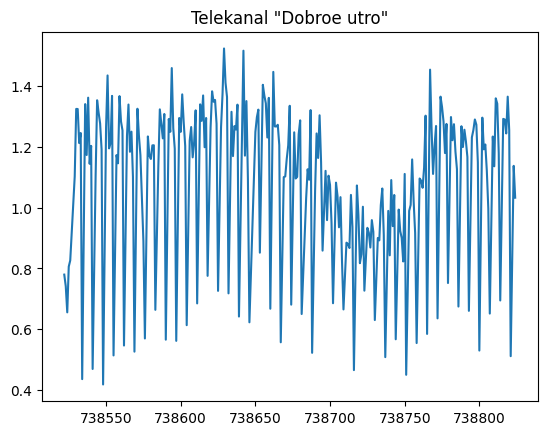

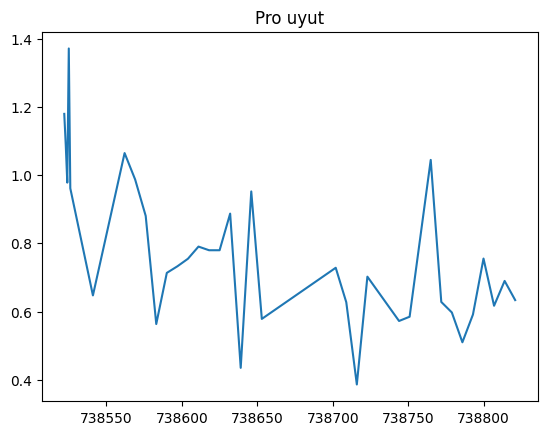

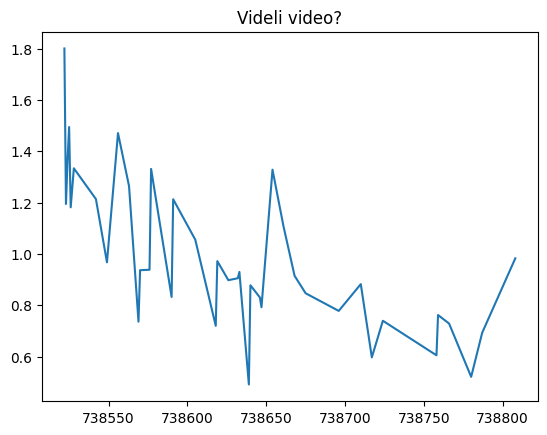

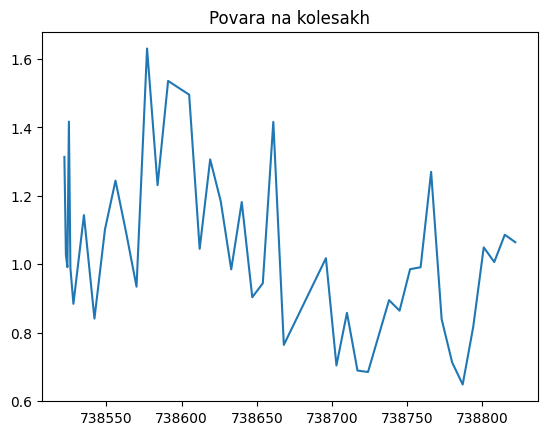

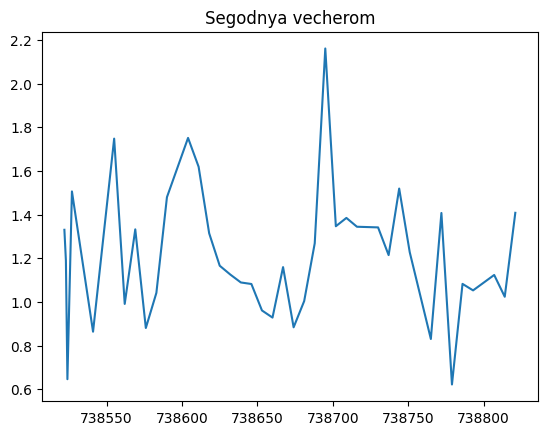

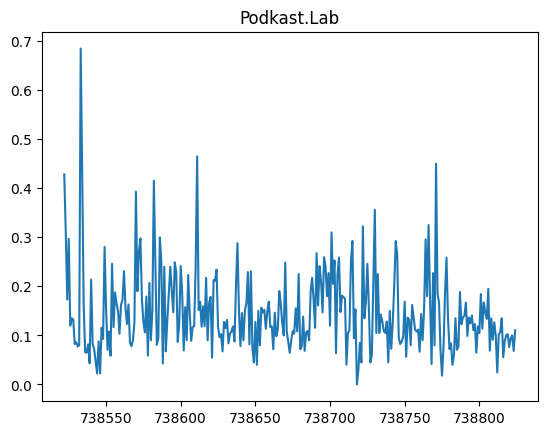

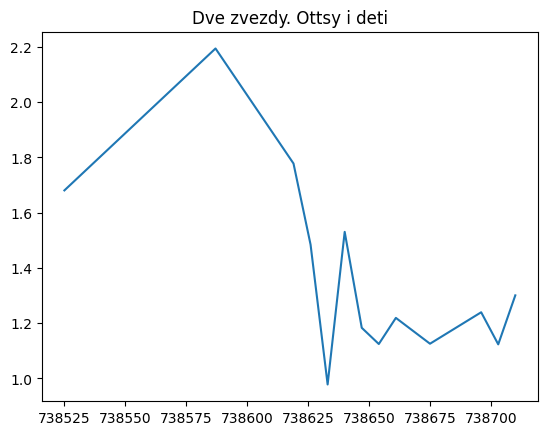

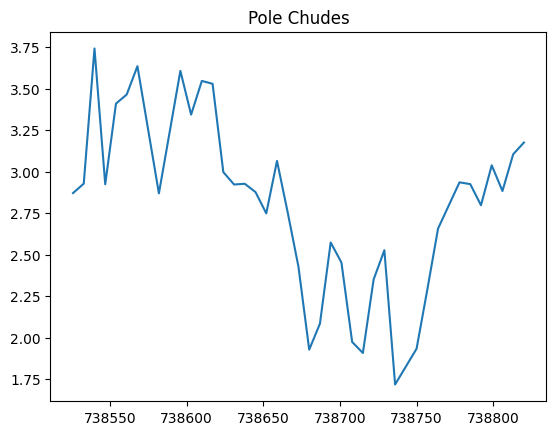

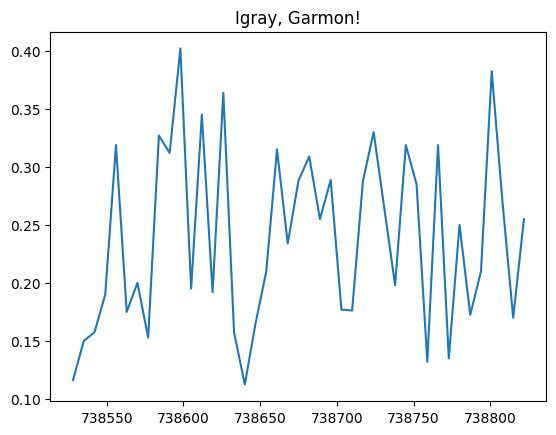

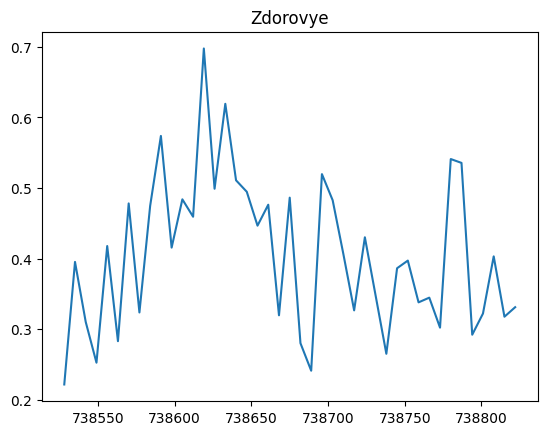

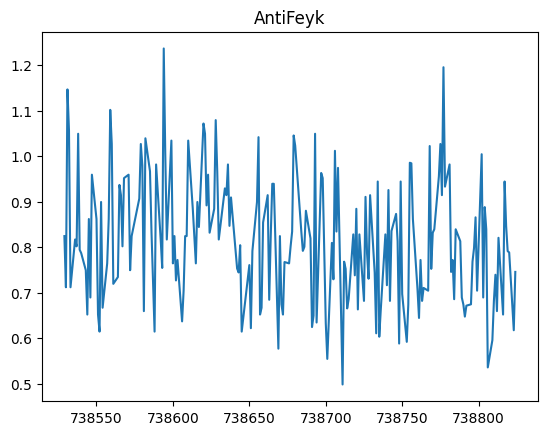

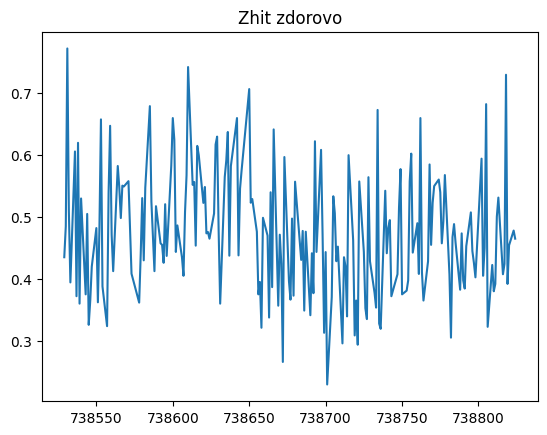

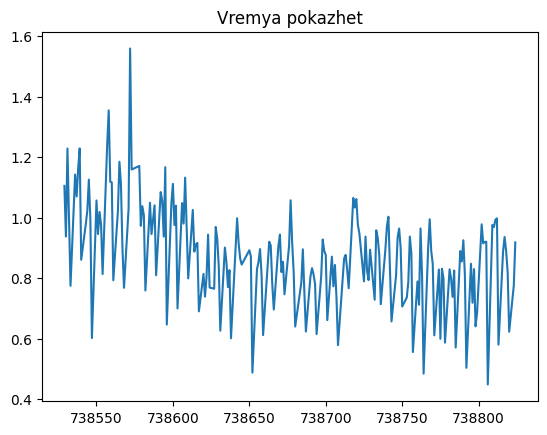

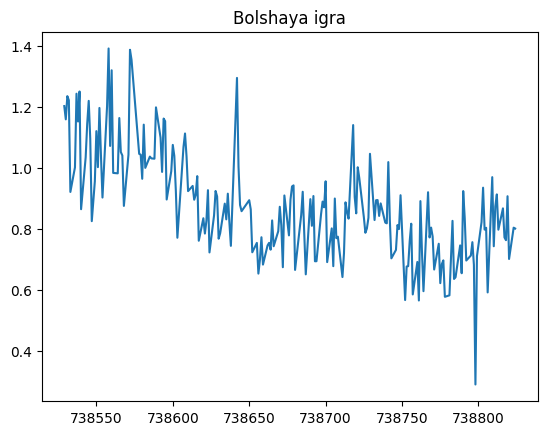

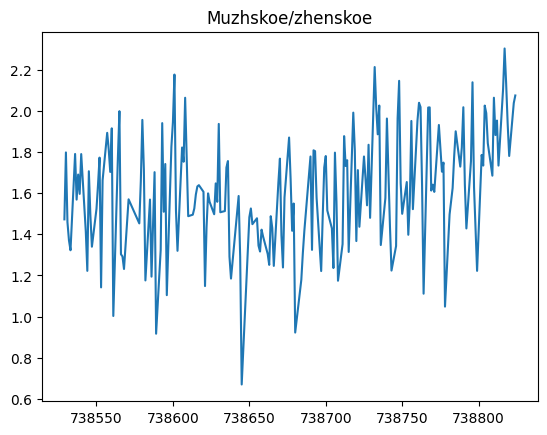

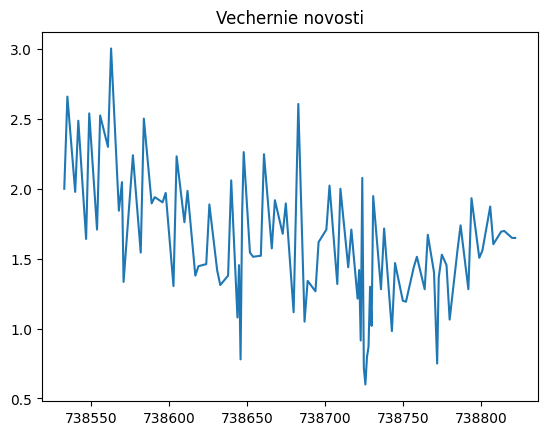

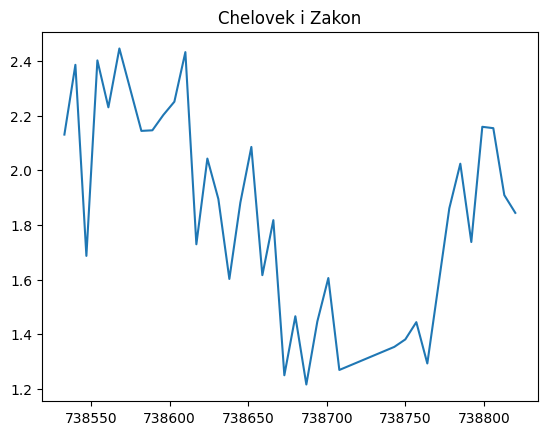

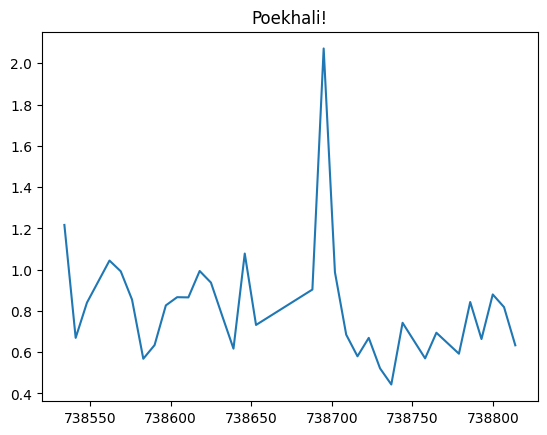

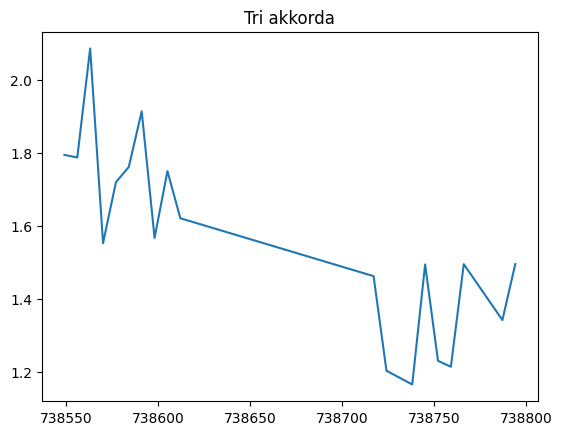

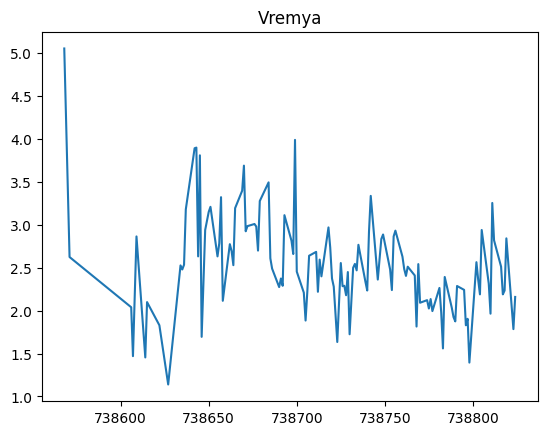

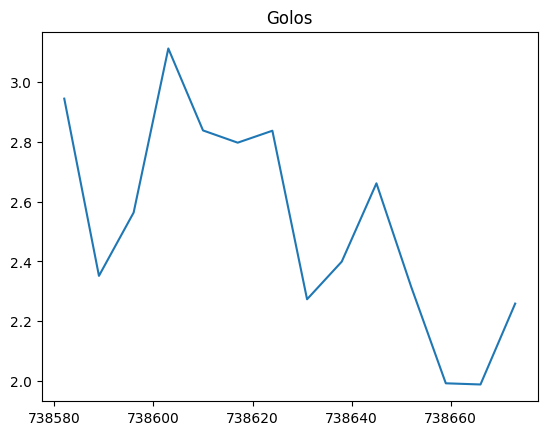

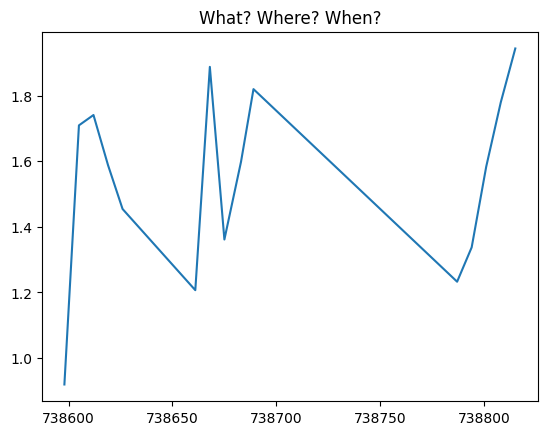

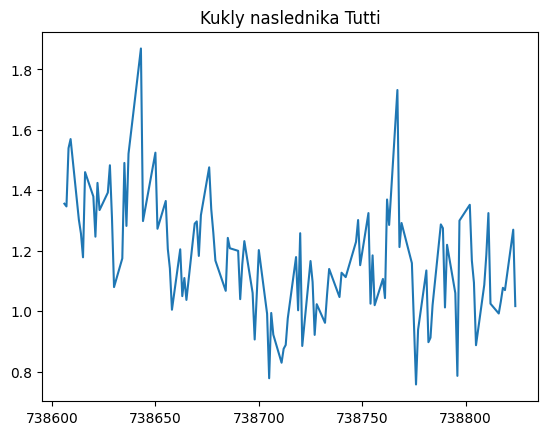

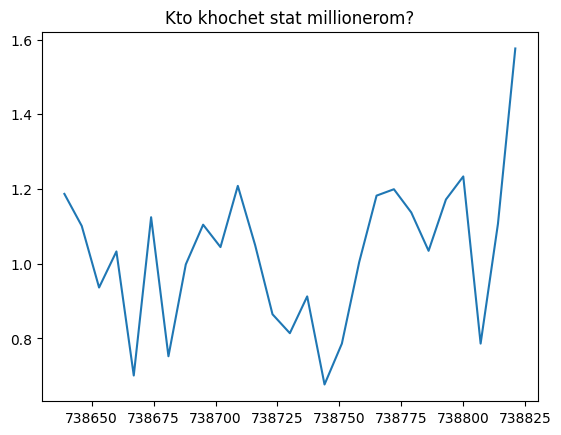

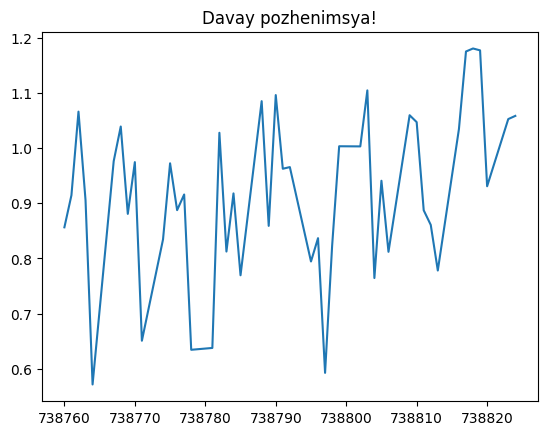

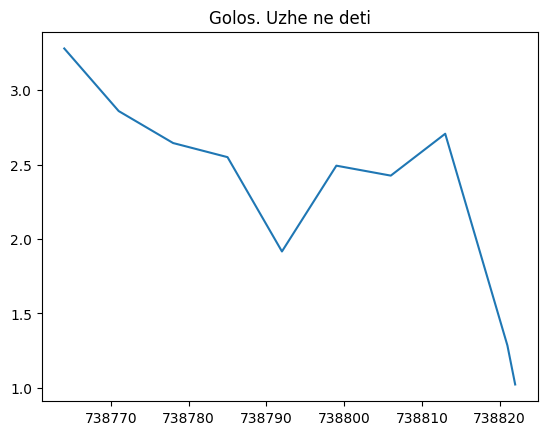

In [251]:
for p in train_df['Programme'].unique():
    plt.plot(train_df.loc[train_df['Programme'] ==p].groupby(by='new_date')[target_column].mean())
    plt.title(p)
    plt.show()

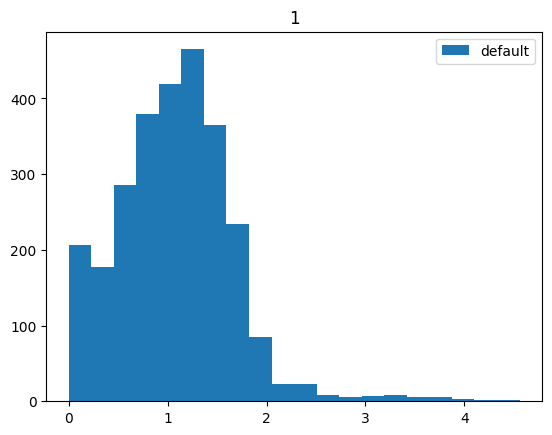

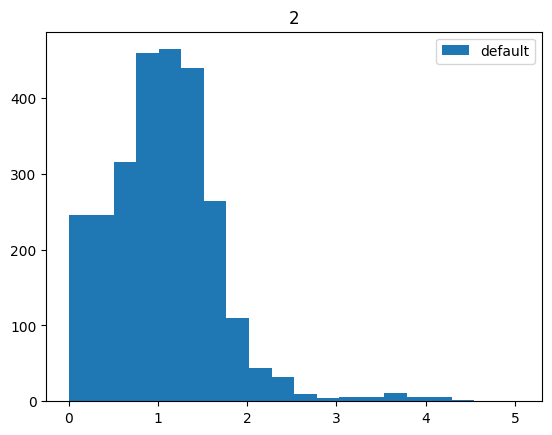

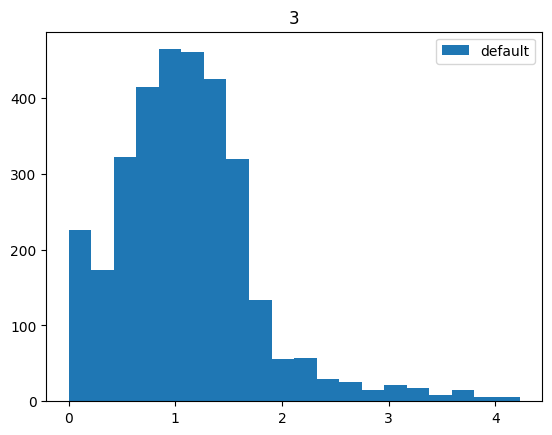

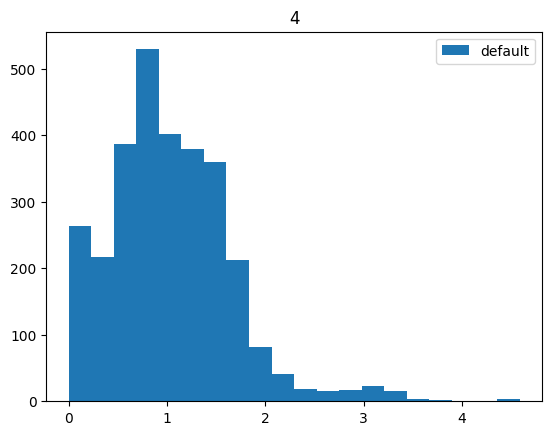

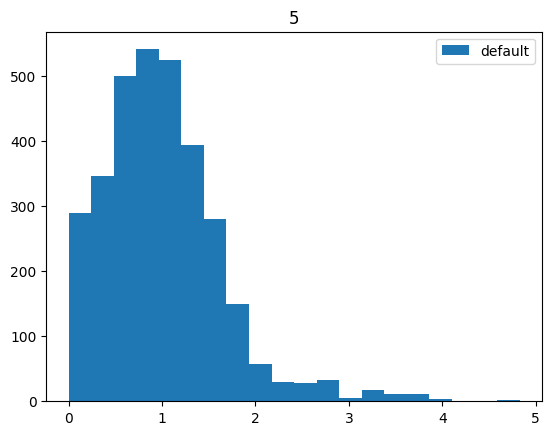

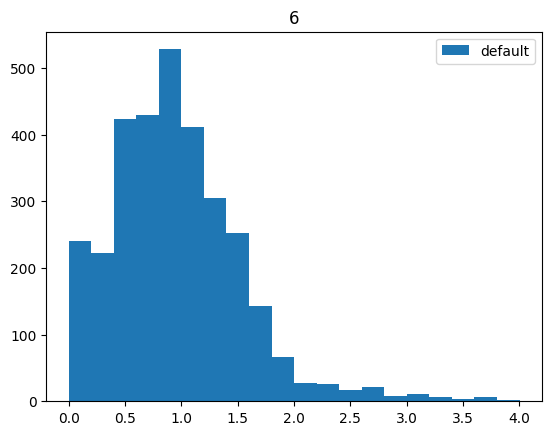

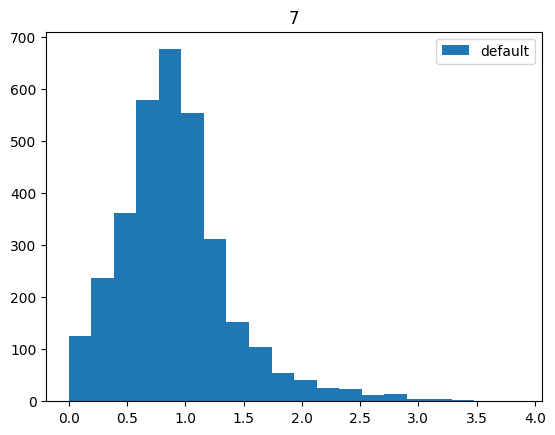

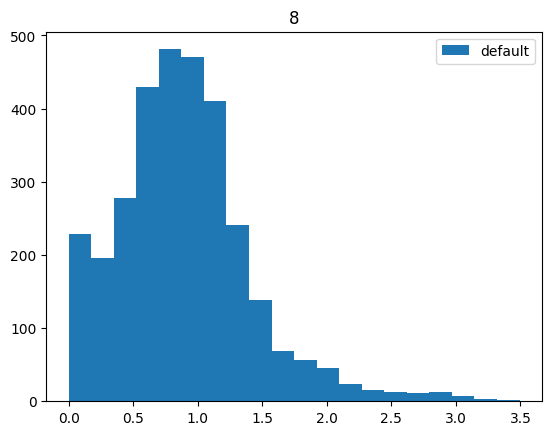

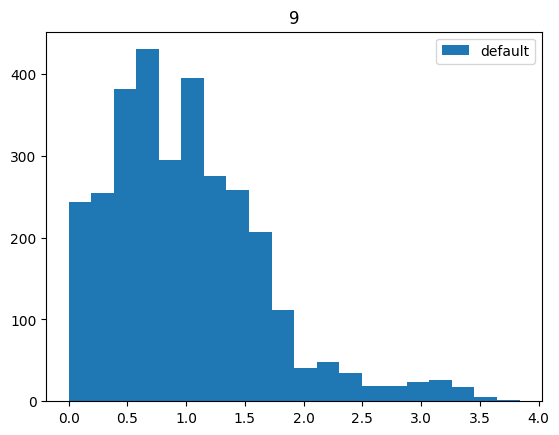

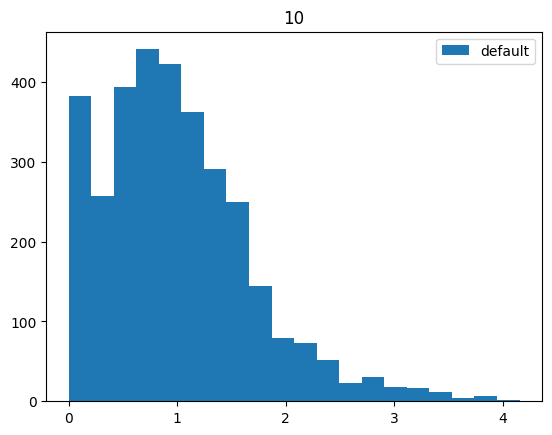

In [108]:
for i in train_df['Date_month'].unique():
    plt.hist(train_df.loc[train_df['Date_month'] == i, target_column], bins=20)
    plt.legend(['default'])
    plt.title(i)
    plt.show()

Обучение модели

In [465]:
def prepare_data(data: pd.DataFrame, mode: str = 'train') -> pd.DataFrame:
    '''Предобработка датасета и генерация новых признаков'''
    train_df = data.copy(deep=True)
    train_df['Date_month'] = train_df['Date'].map(lambda xyz: datetime.strptime(xyz, '%d.%m.%Y').month)
    train_df['new_date'] = train_df['Date'].map(lambda xyz: datetime.strptime(xyz, '%d.%m.%Y').toordinal())
    if mode == 'train':
        target_column = 'TVR Index'
        train_df[target_column] = train_df[target_column].apply(lambda x: float(x.replace(',', '.')))
    train_df['Date_day'] = train_df['Date'].map(lambda xyz: datetime.strptime(xyz, '%d.%m.%Y').day)
    break_start = pd.to_datetime(train_df['Break flight start'].apply(lambda x: ':'.join([str((int(x.split(':')[0]) - 5) % 24), x.split(':')[1], x.split(':')[2]])), format='%H:%M:%S')
    break_end = pd.to_datetime(train_df['Break flight end'].apply(lambda x: ':'.join([str((int(x.split(':')[0]) - 5) % 24), x.split(':')[1], x.split(':')[2]])), format='%H:%M:%S')
    train_df['Break duration'] = (break_end - break_start).dt.seconds
    train_df['Break_hour'] = train_df['Break flight start'].apply(lambda x: int(x.split(':')[0]))
    programm_start = pd.to_datetime(train_df['Programme flight start'].apply(lambda x: ':'.join([str((int(x.split(':')[0]) - 5) % 24), x.split(':')[1], x.split(':')[2]])), format='%H:%M:%S')
    programm_end = pd.to_datetime(train_df['Programme flight end'].apply(lambda x: ':'.join([str((int(x.split(':')[0]) - 5) % 24), x.split(':')[1], x.split(':')[2]])), format='%H:%M:%S')
    train_df['Programm duration'] = (programm_end - programm_start).dt.seconds
    train_df['Programm_hour'] = train_df['Programme flight start'].apply(lambda x: int(x.split(':')[0]))
    train_df.Date = pd.to_datetime(train_df.Date, dayfirst=True)
    train_df['weekday'] = train_df.Date.apply(lambda x: x.weekday())
    train_df['is_weekend'] = train_df['weekday'].apply(lambda x: int(x in([5, 6])))
    train_df['Break flight start'] = pd.to_datetime(train_df['Break flight start'].apply(lambda x: ':'.join([str(int(x.split(':')[0]) % 24), x.split(':')[1], x.split(':')[2]])), format='%H:%M:%S').apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
    train_df['Break flight end'] = pd.to_datetime(train_df['Break flight end'].apply(lambda x: ':'.join([str(int(x.split(':')[0]) % 24), x.split(':')[1], x.split(':')[2]])), format='%H:%M:%S').apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
    train_df['Programme flight start'] = pd.to_datetime(train_df['Programme flight start'].apply(lambda x: ':'.join([str(int(x.split(':')[0]) % 24), x.split(':')[1], x.split(':')[2]])), format='%H:%M:%S').apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
    train_df['Programme flight end'] = pd.to_datetime(train_df['Programme flight end'].apply(lambda x: ':'.join([str(int(x.split(':')[0]) % 24), x.split(':')[1], x.split(':')[2]])), format='%H:%M:%S').apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
    TV_Viewing = [310.8, 319.9, 310.3, 298.1, 276.0, 263.6, 257.9, 252.9, 253.6, 262.4, 281.9, 298.7, 300.9]
    #
    def get_daily_minutes(date):
        year = date.year
        month = date.month
        day = date.day
        if day<15:
            b = TV_Viewing[month] - TV_Viewing[month-1]
            return TV_Viewing[month] - (15 - day) * b / 30
        else:
            b=TV_Viewing[month+1]-TV_Viewing[month]
            return TV_Viewing[month] + (15 - day) * b / 30

    train_df['views_minutes'] = pd.to_datetime(train_df['Date']).apply(get_daily_minutes)
    return train_df
    

In [531]:
train = pd.read_csv('train.csv', sep=';')
train_df = prepare_data(train)
train_df.head()

,TVR Index,Date,Break flight ID,Break flight start,Break flight end,Break content,Break distribution,Programme,Programme flight start,Programme flight end,...,Date_month,new_date,Date_day,Break duration,Break_hour,Programm duration,Programm_hour,weekday,is_weekend,views_minutes
0,0.614693,2023-01-02,4870830561,29853,30100,Commercial,Network,"Telekanal ""Dobroe utro""",28813,36014,...,1,738522,2,247,8,7201,8,0,0,315.956667
1,0.869565,2023-01-02,4870830614,30885,31132,Commercial,Network,"Telekanal ""Dobroe utro""",28813,36014,...,1,738522,2,247,8,7201,8,0,0,315.956667
2,0.989505,2023-01-02,4870830629,31939,32183,Commercial,Network,"Telekanal ""Dobroe utro""",28813,36014,...,1,738522,2,244,8,7201,8,0,0,315.956667
3,0.884558,2023-01-02,4870830684,32191,32248,Announcement,Network,"Telekanal ""Dobroe utro""",28813,36014,...,1,738522,2,57,8,7201,8,0,0,315.956667
4,0.839580,2023-01-02,4870830685,33124,33373,Commercial,Network,"Telekanal ""Dobroe utro""",28813,36014,...,1,738522,2,249,9,7201,8,0,0,315.956667


In [532]:
train_df = train_df.loc[train_df[target_column] > 0].reset_index(drop=True)

In [445]:
target_column = 'TVR Index'
cat_features = ['Break content',
 'Break distribution',
 'Programme',
 'Programme category',
 'Programme genre',
 'is_weekend', #является день выходным или нет
 'weekday', #номер дня недели 0 - пн, ... , 6 - вс
 'Date_month'] #месяц из даты
train_cols = ['Break content',
 'Break distribution',
 'Programme',
 'Programme category',
 'Programme genre',
 'Date_month',
 'new_date', #дата в форме одного числа
 'Date_day', #день из даты
 'Break duration', #длительность рекламы
 'Break_hour', #час, в который началась реклама
 'Programm duration', #длительность програмы
 'Programm_hour', #час, в который началась программа
 'weekday',
 'is_weekend',
 'Break flight start',
 'Break flight end',
 'Programme flight start',
 'Programme flight end',
 'views_minutes'] #среднее время просмотра в минутах

In [541]:
y_train[X_train.loc[X_train['Programme'] == 'Podkast.Lab'].index]

53       0.734633
54       0.644678
55       0.659670
56       0.524738
57       0.434783
           ...   
27788    0.074963
27789    0.059970
27790    0.014993
27791    0.014993
27792    0.014993
Name: TVR Index, Length: 2275, dtype: float64

In [539]:
X_train.Programme

0        Telekanal "Dobroe utro"
1        Telekanal "Dobroe utro"
2        Telekanal "Dobroe utro"
3        Telekanal "Dobroe utro"
4        Telekanal "Dobroe utro"
                  ...           
27788                Podkast.Lab
27789                Podkast.Lab
27790                Podkast.Lab
27791                Podkast.Lab
27792                Podkast.Lab
Name: Programme, Length: 27793, dtype: category
Categories (26, object): ['AntiFeyk', 'Bolshaya igra', 'Chelovek i Zakon', 'Davay pozhenimsya!', ..., 'Vremya pokazhet', 'What? Where? When?', 'Zdorovye', 'Zhit zdorovo']

In [560]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
tscv = TimeSeriesSplit(n_splits=10) #Валидируемся по временному ряду
models = {}
errors = {}
errors_tr = {}
train_errors = {i: [] for i in train_df['Programme'].unique()}
val_errors = {i: [] for i in train_df['Programme'].unique()}
y = train_df[target_column]
X = train_df[train_cols]
X[cat_features] = X[cat_features].astype('category')
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = LGBMRegressor(objective='mape', verbose=0)
    clf.fit(X_train, y_train)
    models[i] = clf
    preds = clf.predict(X_test)
    for j in train_df['Programme'].unique():
        try:
            train_errors[j].append(mean_absolute_percentage_error(y_train[X_train.loc[X_train['Programme'] == j].index], clf.predict(X_train.loc[X_train['Programme'] == j])))
            val_errors[j].append(mean_absolute_percentage_error(y_test[X_test.loc[X_test['Programme'] == j].index], clf.predict(X_test.loc[X_test['Programme'] == j])))
        except:
            continue
    errors[i] = mean_absolute_percentage_error(y_test, preds)
    errors_tr[i] = mean_absolute_percentage_error(y_train, clf.predict(X_train))
print(errors)
print(np.mean(list(errors.values())))        

C:\Users\HP\AppData\Local\Temp\ipykernel_9052\3028736070.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Some label values are < 1 in absolute value. MAPE is unstable with such values, so LightGBM rounds them to 1.0 when calculating MAPE.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Some label values are < 1 in absolute value. MAPE is unstable with such values, so LightGBM rounds them to 1.0 when calculating MAPE.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Some label values are < 1 in absolute value. MAPE is unstable with such values, so LightGBM rounds them to 1.0 when calculating MAPE.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Some label values are < 1 in absolute value. MAPE is unstable with such values, so LightGBM rounds them to 1.0 when calculating MAPE.
[LightGBM] [Warning] Found whitespace in feature_names, repl

In [561]:
np.array(list(errors_tr.values())).mean()

0.15529663823605755

In [557]:
train_errors = {k: sum(v)/len(v) for k, v in train_errors.items()}
val_errors = {k: sum(v)/len(v) for k, v in val_errors.items()}

In [558]:
train_errors

{'Telekanal "Dobroe utro"': 0.10419795869910953,
 'Pro uyut': 0.11567679343748079,
 'Videli video?': 0.12372710432665426,
 'Povara na kolesakh': 0.1404406583283717,
 'Segodnya vecherom': 0.17853313764897166,
 'Podkast.Lab': 0.4258318380187028,
 'Dve zvezdy. Ottsy i deti': 0.16375690410071636,
 'Pole Chudes': 0.18817589260720327,
 'Igray, Garmon!': 0.24070652610629756,
 'Zdorovye': 0.22549320241800022,
 'AntiFeyk': 0.11460552750078838,
 'Zhit zdorovo': 0.168910076108083,
 'Vremya pokazhet': 0.13636251307140748,
 'Bolshaya igra': 0.12490008073773962,
 'Muzhskoe/zhenskoe': 0.14599894471064473,
 'Vechernie novosti': 0.18796250865520409,
 'Chelovek i Zakon': 0.15803630480818764,
 'Poekhali!': 0.1661199475024708,
 'Tri akkorda': 0.1636018877121692,
 'Vremya': 0.2674437199269043,
 'Golos': 0.12713237275536177,
 'What? Where? When?': 0.16949877706036318,
 'Kukly naslednika Tutti': 0.10910237945485231,
 'Kto khochet stat millionerom?': 0.1753030375483697,
 'Davay pozhenimsya!': 0.11000611123198

In [559]:
val_errors

{'Telekanal "Dobroe utro"': 0.15658594068539428,
 'Pro uyut': 0.29676304407191656,
 'Videli video?': 0.2508904821515894,
 'Povara na kolesakh': 0.24337551839801494,
 'Segodnya vecherom': 0.25962156580585743,
 'Podkast.Lab': 0.5746081256766928,
 'Dve zvezdy. Ottsy i deti': 0.2675241926339999,
 'Pole Chudes': 0.21101560939250757,
 'Igray, Garmon!': 0.4307508878742038,
 'Zdorovye': 0.2851056052939175,
 'AntiFeyk': 0.1576493806463671,
 'Zhit zdorovo': 0.2316179122653636,
 'Vremya pokazhet': 0.21227716125479162,
 'Bolshaya igra': 0.21795862198819344,
 'Muzhskoe/zhenskoe': 0.18419452629005204,
 'Vechernie novosti': 0.19739588106674955,
 'Chelovek i Zakon': 0.21141220310763198,
 'Poekhali!': 0.2769557221700472,
 'Tri akkorda': 0.18177546312790668,
 'Vremya': 0.23740673957040898,
 'Golos': 0.15838063852592046,
 'What? Where? When?': 0.23122795881927014,
 'Kukly naslednika Tutti': 0.16897541677816144,
 'Kto khochet stat millionerom?': 0.22778451190190527,
 'Davay pozhenimsya!': 0.21252291814722

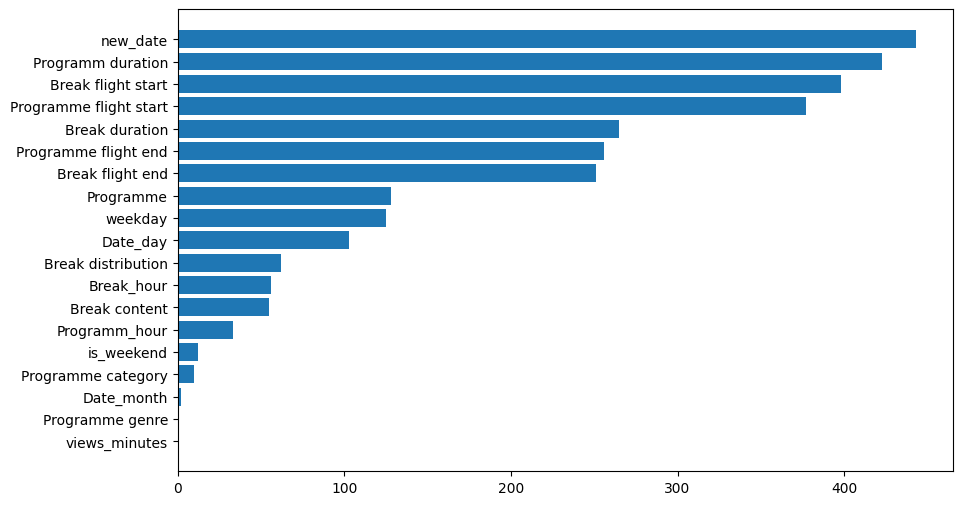

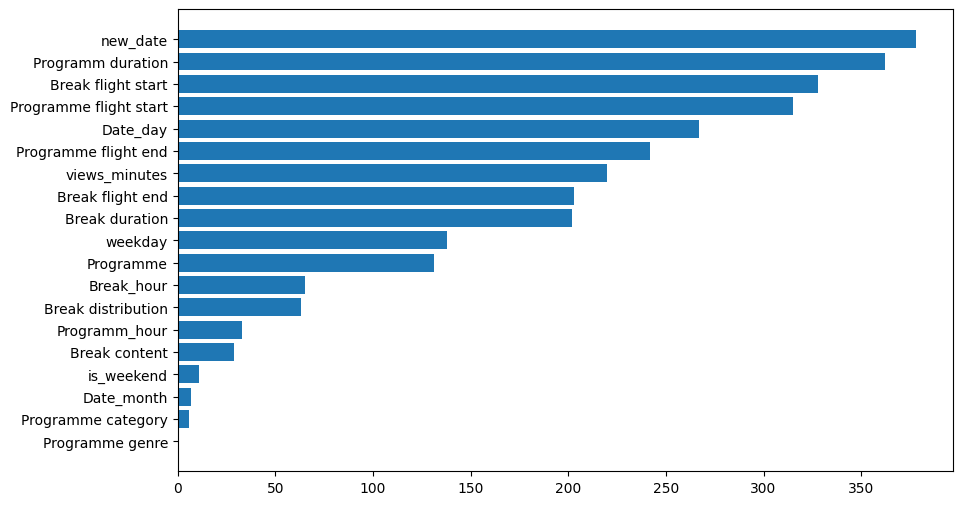

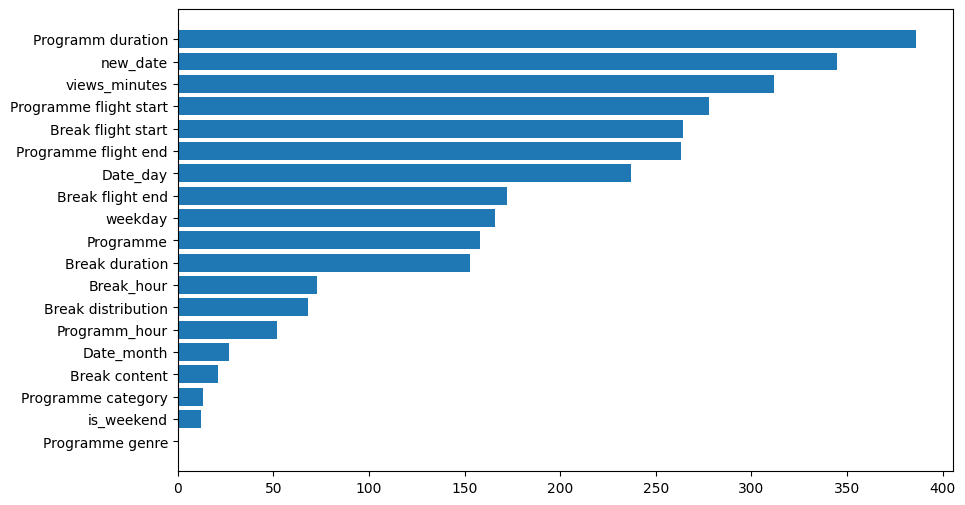

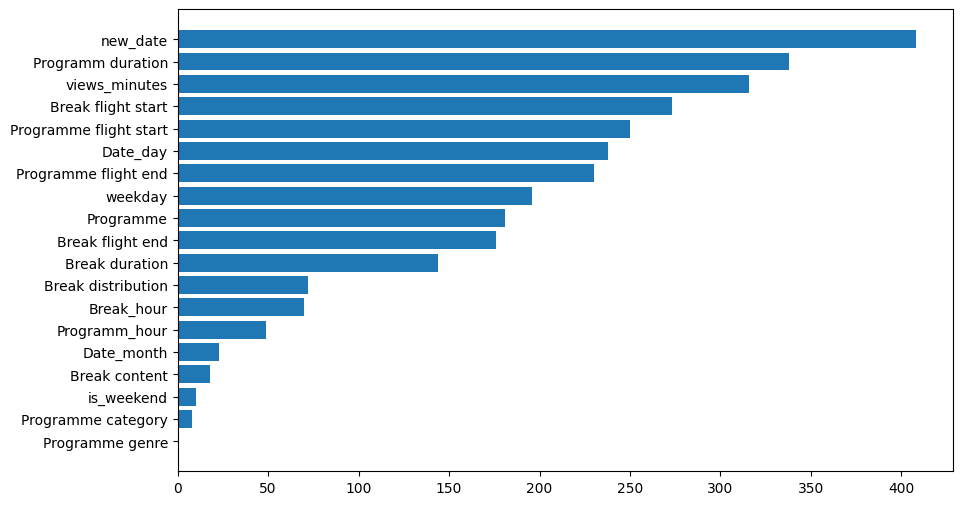

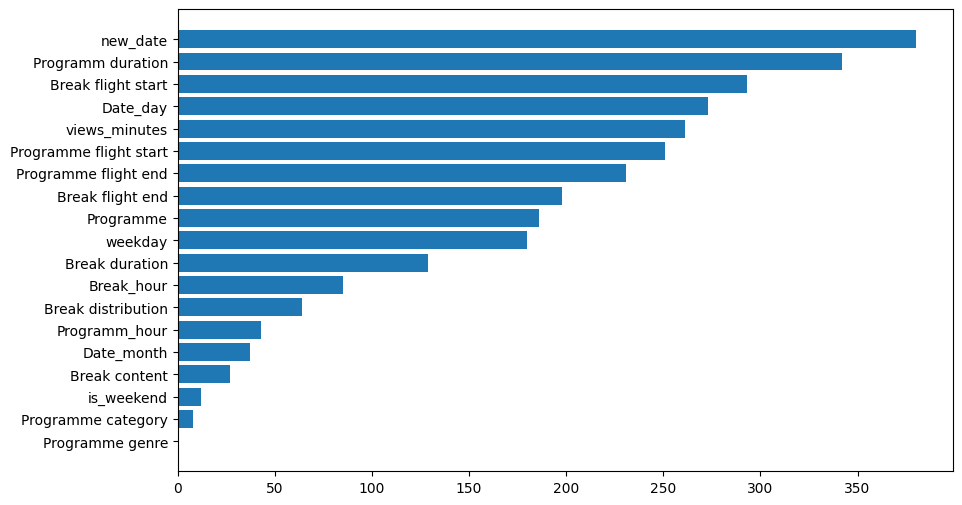

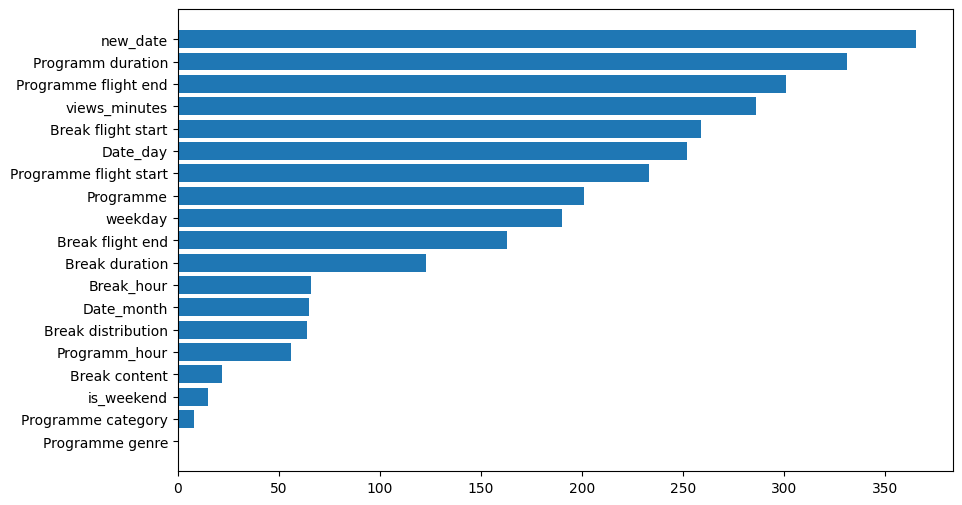

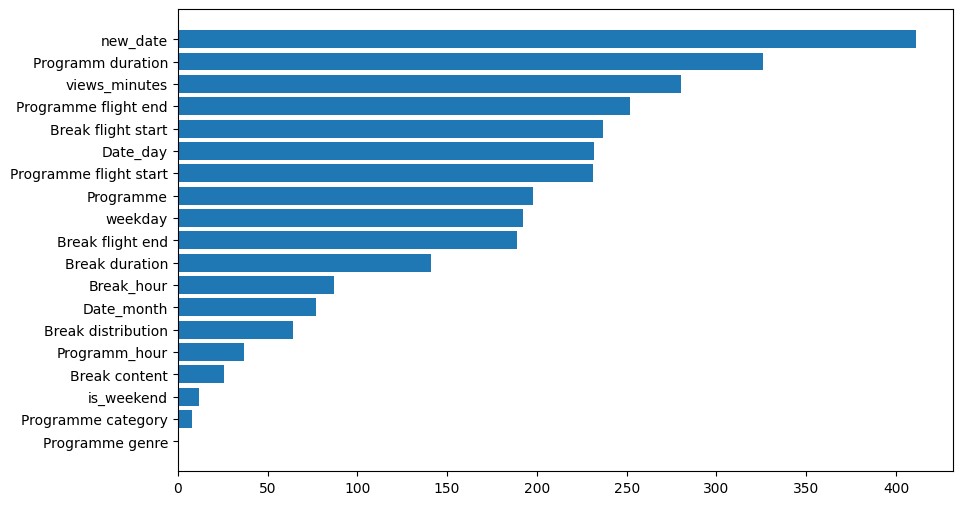

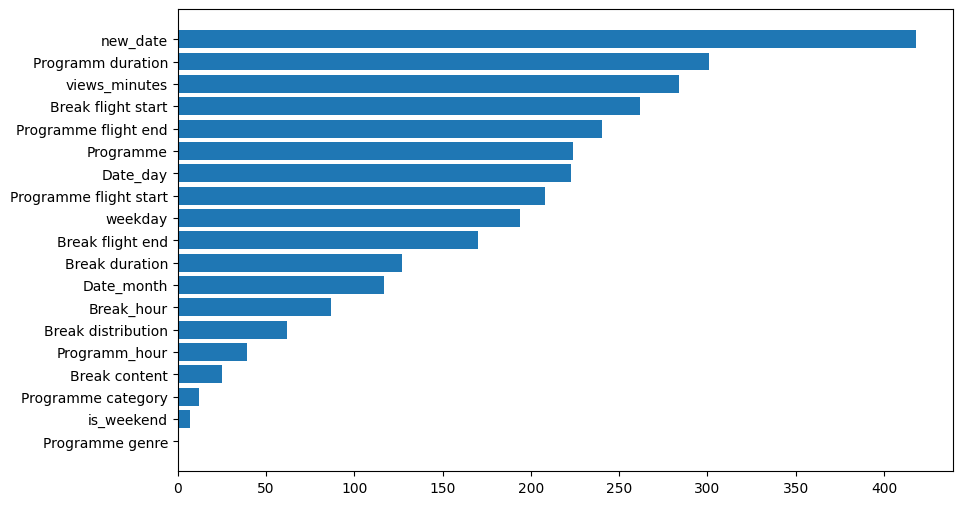

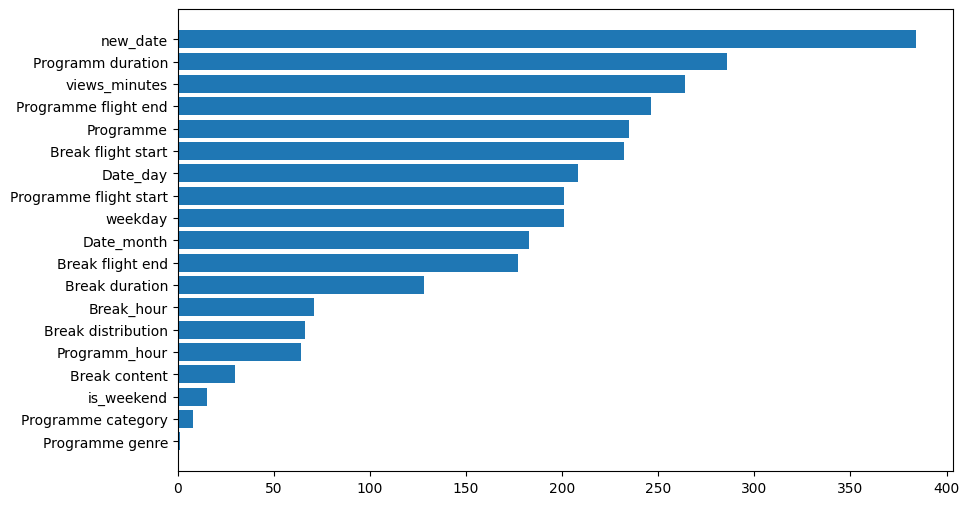

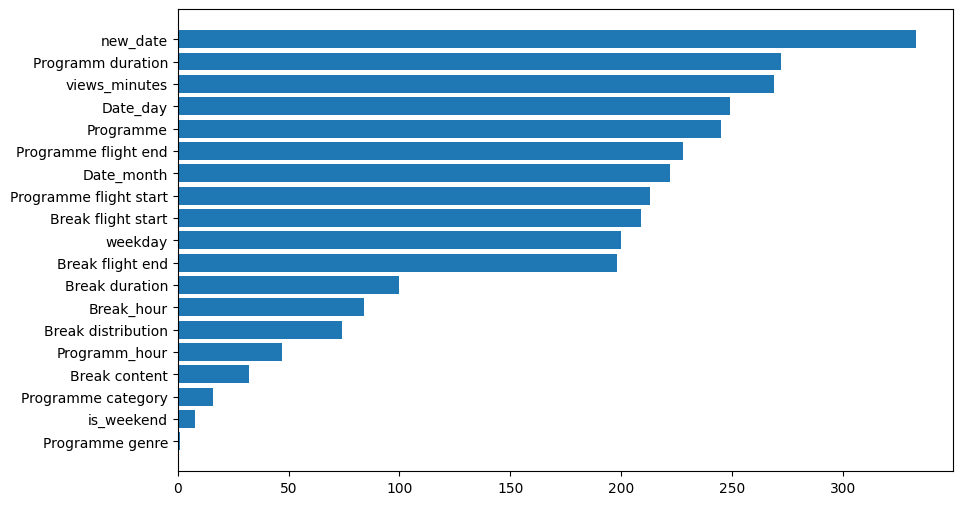

In [513]:
#Важность признаков
import matplotlib.pyplot as plt
for model in models.values():

    importances = model.feature_importances_
    feature_importances = pd.Series(importances, index=X.columns).sort_values()
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances.index, feature_importances.values)
    plt.show()

In [514]:
#Подготовка тестовых данных
test_df = pd.read_csv('test.csv', sep=';')

test = prepare_data(test_df, mode='test')
test[cat_features] = test[cat_features].astype('category')
test.head()

,Date,Break flight ID,Break flight start,Break flight end,Break content,Break distribution,Programme,Programme flight start,Programme flight end,Programme category,...,Date_month,new_date,Date_day,Break duration,Break_hour,Programm duration,Programm_hour,weekday,is_weekend,views_minutes
0,2023-11-01,5336499245,19116,19147,Announcement,Network,"Telekanal ""Dobroe utro""",18378,19815,Morning airplay,...,11,738825,1,31,5,1437,5,2,0,290.86
1,2023-11-01,5336499246,19551,19620,Announcement,Network,"Telekanal ""Dobroe utro""",18378,19815,Morning airplay,...,11,738825,1,69,5,1437,5,2,0,290.86
2,2023-11-01,5336499251,20951,21004,Announcement,Network,"Telekanal ""Dobroe utro""",20176,21615,Morning airplay,...,11,738825,1,53,5,1439,5,2,0,290.86
3,2023-11-01,5336499255,22164,22349,Commercial,Network,"Telekanal ""Dobroe utro""",21979,23415,Morning airplay,...,11,738825,1,185,6,1436,6,2,0,290.86
4,2023-11-01,5336499270,22355,22426,Announcement,Network,"Telekanal ""Dobroe utro""",21979,23415,Morning airplay,...,11,738825,1,71,6,1436,6,2,0,290.86


In [515]:
preds = np.array([m.predict(test[train_cols]) for m in models.values()]).mean(axis=0)
test_df['TVR Index Forecast'] = preds

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:693: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:693: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:693: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [473]:
test_df.head()

,Date,Break flight ID,Break flight start,Break flight end,Break content,Break distribution,Programme,Programme flight start,Programme flight end,Programme category,Programme genre,TVR Index Forecast
0,01.11.2023,5336499245,5:18:36,5:19:07,Announcement,Network,"Telekanal ""Dobroe utro""",5:06:18,5:30:15,Morning airplay,Entertainment programs,0.212339
1,01.11.2023,5336499246,5:25:51,5:27:00,Announcement,Network,"Telekanal ""Dobroe utro""",5:06:18,5:30:15,Morning airplay,Entertainment programs,0.221904
2,01.11.2023,5336499251,5:49:11,5:50:04,Announcement,Network,"Telekanal ""Dobroe utro""",5:36:16,6:00:15,Morning airplay,Entertainment programs,0.508479
3,01.11.2023,5336499255,6:09:24,6:12:29,Commercial,Network,"Telekanal ""Dobroe utro""",6:06:19,6:30:15,Morning airplay,Entertainment programs,1.092506
4,01.11.2023,5336499270,6:12:35,6:13:46,Announcement,Network,"Telekanal ""Dobroe utro""",6:06:19,6:30:15,Morning airplay,Entertainment programs,1.100183


In [516]:
test['TVR Index Forecast'] = preds
test.rename(columns={'TVR Index Forecast': 'TVR Index'}, inplace=True)
test.head()

,Date,Break flight ID,Break flight start,Break flight end,Break content,Break distribution,Programme,Programme flight start,Programme flight end,Programme category,...,Date_month,new_date,Date_day,Break duration,Break_hour,Programm duration,Programm_hour,weekday,is_weekend,views_minutes
0,2023-11-01,5336499245,19116,19147,Announcement,Network,"Telekanal ""Dobroe utro""",18378,19815,Morning airplay,...,11,738825,1,31,5,1437,5,2,0,290.86
1,2023-11-01,5336499246,19551,19620,Announcement,Network,"Telekanal ""Dobroe utro""",18378,19815,Morning airplay,...,11,738825,1,69,5,1437,5,2,0,290.86
2,2023-11-01,5336499251,20951,21004,Announcement,Network,"Telekanal ""Dobroe utro""",20176,21615,Morning airplay,...,11,738825,1,53,5,1439,5,2,0,290.86
3,2023-11-01,5336499255,22164,22349,Commercial,Network,"Telekanal ""Dobroe utro""",21979,23415,Morning airplay,...,11,738825,1,185,6,1436,6,2,0,290.86
4,2023-11-01,5336499270,22355,22426,Announcement,Network,"Telekanal ""Dobroe utro""",21979,23415,Morning airplay,...,11,738825,1,71,6,1436,6,2,0,290.86


In [517]:
final = pd.concat((train_df, test))

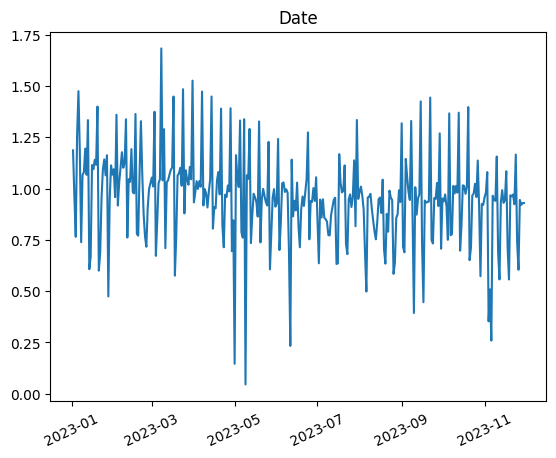

In [518]:
plt.plot(final.groupby(by='Date')['TVR Index'].mean())

#plt.legend(['true', 'preds'])
plt.title('Date')
plt.xticks(rotation = 25)
plt.show()

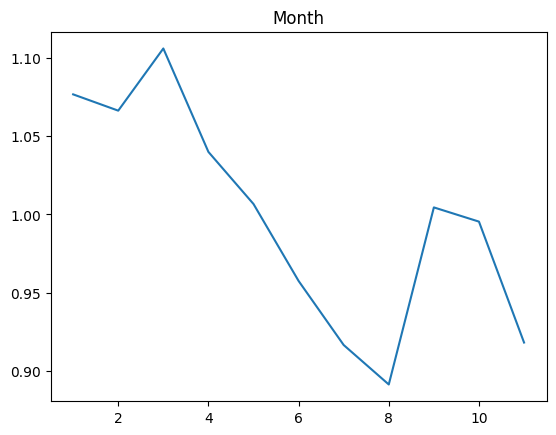

In [519]:
plt.plot(final.groupby(by='Date_month')['TVR Index'].mean())
#plt.legend(['true', 'preds'])
plt.title('Month')
plt.show()

In [566]:
test_df.to_excel('submission.xlsx', index=False)